In [3]:
!git clone https://github.com/kaapthijs/DMT-A1.git

Cloning into 'DMT-A1'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 91 (delta 28), reused 41 (delta 12), pack-reused 31
Receiving objects: 100% (91/91), 30.48 MiB | 4.71 MiB/s, done.
Resolving deltas: 100% (42/42), done.
Updating files: 100% (13/13), done.


In [4]:
import os
os.chdir('DMT-A1')

In [6]:
import pandas as pd
import numpy as np
from feature_engineering import create_features,select_features
import random

#SEED = np.random.randint(100)
SEED = 60
np.random.seed(SEED), random.seed(SEED)
print(f"SEED: {SEED}")
#pd.set_option('future.no_silent_downcasting', True)
dataset = pd.read_csv('./cleaned_dataset.csv')
# Creating features
X, y = create_features(dataset,window_size=5)

SEED: 60


In [7]:
#add the previous days mood as a variable
X.shape, y.shape
X['mood_final'] = y
X.shape, y.shape

((1196, 33), (1196, 1))

In [8]:
#create sequences for the LSTM
def create_sequences(X, y, sequence_length=5):
    X_final= []
    y_final = []
    for i in range(len(X) - sequence_length):
        X_final.append(X.iloc[i:i + sequence_length, :].values)
        y_final.append(y.iloc[i:i + sequence_length])
    return np.array(X_final), np.array(y_final)

X_seq, y_seq = create_sequences(X, y, sequence_length=5)

In [9]:
from sklearn.model_selection import train_test_split

#custom train test split for sequential data
def train_test_split_custom(data, train_size=0.8):
    split_idx = int(len(data) * train_size)
    train = data[:split_idx]
    test = data[split_idx:]
    return train, test


'''
X_train, X_test = train_test_split(X_seq, train_size=0.75, stratify = (y_seq[:,-1] > 7.5).astype(int))
y_train, y_test = train_test_split(y_seq, train_size=0.75,stratify = (y_seq[:,-1] > 7.5).astype(int))
X_train.shape,y_train.shape, X_test.shape,y_test.shape
'''
X_train, X_test = train_test_split_custom(X_seq, train_size=0.8)
y_train, y_test = train_test_split_custom(y[5:], train_size=0.8)
X_train.shape,y_train.shape, X_test.shape,y_test.shape


((952, 5, 33), (952, 1), (239, 5, 33), (239, 1))

In [10]:
y_train.head()

,mood
5,6.272727
6,7.800000
7,8.000000
8,7.800000
9,6.461538


In [11]:
#create sequences for the LSTM
def create_sequences(X, y, sequence_length=5):
    X_final= []
    y_final = []
    for i in range(len(X) - sequence_length):
        X_final.append(X.iloc[i:i + sequence_length, :].values)
        y_final.append(y.iloc[i:i + sequence_length])
    return np.array(X_final), np.array(y_final)

X_seq, y_seq = create_sequences(X, y, sequence_length=5)


In [12]:
from sklearn.model_selection import train_test_split

#custom train test split for sequential data
def train_test_split_custom(data, train_size=0.8):
    split_idx = int(len(data) * train_size)
    train = data[:split_idx]
    test = data[split_idx:]
    return train, test


'''
X_train, X_test = train_test_split(X_seq, train_size=0.75, stratify = (y_seq[:,-1] > 7.5).astype(int))
y_train, y_test = train_test_split(y_seq, train_size=0.75,stratify = (y_seq[:,-1] > 7.5).astype(int))
X_train.shape,y_train.shape, X_test.shape,y_test.shape
'''
X_train, X_test = train_test_split_custom(X_seq, train_size=0.8)
y_train, y_test = train_test_split_custom(y[4:-1], train_size=0.8)
X_train.shape,y_train.shape, X_test.shape,y_test.shape

X_train.shape,y_train.shape, X_test.shape,y_test.shape

((952, 5, 33), (952, 1), (239, 5, 33), (239, 1))

In [13]:
#normalize the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train.reshape(-1,X_train.shape[2]))

X_train_scaled = scaler.transform(np.reshape(X_train, (-1, X_train.shape[2])))
X_test_scaled = scaler.transform(np.reshape(X_test, (-1, X_test.shape[2])))

# Reshape back to the original dimensions
X_train_scaled = np.reshape(X_train_scaled, X_train.shape)
X_test_scaled = np.reshape(X_test_scaled, X_test.shape)

In [60]:
from tensorflow.keras.layers import Dropout, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.layers import GRU



timesteps = X_train_scaled.shape[1]  # Number of timesteps in the input/output sequence
features = X_train_scaled.shape[2] # Number of features in the input
output_units = 1  # Output dimension (1 for binary classification at each timestep)




model = Sequential([
    LSTM(100, return_sequences=True,input_shape=(timesteps, features)),
    Dropout(0.5),
    LSTM(100),
    Dense(1, activation='linear')
])
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_absolute_error'])
model.summary()



Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 5, 100)            53600     
                                                                 
 dropout_8 (Dropout)         (None, 5, 100)            0         
                                                                 
 lstm_13 (LSTM)              (None, 100)               80400     
                                                                 
 dense_8 (Dense)             (None, 1)                 101       
                                                                 
Total params: 134101 (523.83 KB)
Trainable params: 134101 (523.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [61]:
history = model.fit(
    X_train_scaled,
    y_train,            # Training data and labels
    epochs=17,                   # Number of epochs to train for
    batch_size=16,               # Batch size for training
    validation_split=0.2,        # Fraction of data to use for validation
    verbose=1,                   # Show detailed progress in the output

)


Epoch 1/17
48/48 [==============================] - 7s 33ms/step - loss: 2.2033 - mean_absolute_error: 2.2033 - val_loss: 0.4556 - val_mean_absolute_error: 0.4556
Epoch 2/17
48/48 [==============================] - 1s 16ms/step - loss: 0.4047 - mean_absolute_error: 0.4047 - val_loss: 0.4770 - val_mean_absolute_error: 0.4770
Epoch 3/17
48/48 [==============================] - 1s 21ms/step - loss: 0.4001 - mean_absolute_error: 0.4001 - val_loss: 0.4341 - val_mean_absolute_error: 0.4341
Epoch 4/17
48/48 [==============================] - 1s 23ms/step - loss: 0.3884 - mean_absolute_error: 0.3884 - val_loss: 0.4251 - val_mean_absolute_error: 0.4251
Epoch 5/17
48/48 [==============================] - 1s 21ms/step - loss: 0.3846 - mean_absolute_error: 0.3846 - val_loss: 0.4218 - val_mean_absolute_error: 0.4218
Epoch 6/17
48/48 [==============================] - 1s 14ms/step - loss: 0.3899 - mean_absolute_error: 0.3899 - val_loss: 0.4444 - val_mean_absolute_error: 0.4444
Epoch 7/17
48/48 [====

In [62]:
y_pred = model.predict(X_test_scaled)

8/8 [==============================] - 1s 4ms/step


<class 'numpy.ndarray'>
(2,)


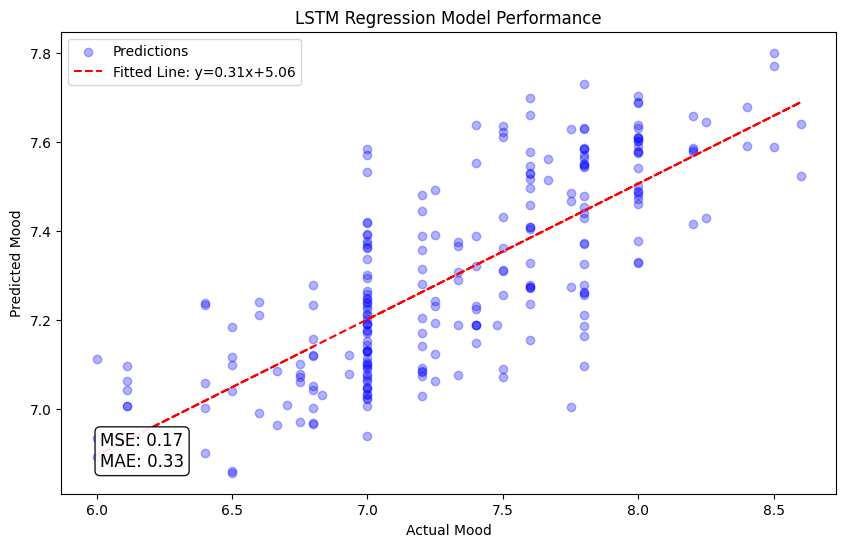

In [63]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

def evaluate_regression(y_test, y_pred, title):
    # Compute metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)  # Root Mean Squared Error

    # Plotting predicted vs actual values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.3, color='blue', label='Predictions')

    # Fit line to the data
    # Fit a linear polynomial (degree 1) to the data
    z = np.polyfit(y_test.flatten(), y_pred, 1)
    z = np.array(z).flatten()
    print(type(z))
    print(z.shape)
    p = np.poly1d(z)

    # Plot the fitted line over the range of y_test values
    plt.plot(y_test, p(y_test), "r--", label=f'Fitted Line: y={z[0]:.2f}x+{z[1]:.2f}')

    plt.title(title)
    plt.xlabel('Actual Mood')
    plt.ylabel('Predicted Mood')
    plt.legend()

    # Add text for MSE and MAE inside the plot
    plt.text(0.05, 0.05, f'MSE: {mse:.2f}\nMAE: {mae:.2f}', transform=plt.gca().transAxes, fontsize=12,
             verticalalignment='bottom', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white', alpha=0.9))

    plt.show()

evaluate_regression(np.array(y_test), np.array(y_pred), 'LSTM Regression Model Performance')


In [64]:
#classification  of the regression result
y_pred_binary = (y_pred > 7.5).astype(int)
y_test_binary = (y_test > 7.5).astype(int)



Accuracy score: 0.79
F1 score: 0.78
Classification Report:
              precision    recall  f1-score   support

    Low mood       0.77      0.95      0.85       148
   High mood       0.86      0.55      0.67        91

    accuracy                           0.79       239
   macro avg       0.82      0.75      0.76       239
weighted avg       0.81      0.79      0.78       239

Confusion Matrix:
[[140   8]
 [ 41  50]]


<Figure size 1000x800 with 0 Axes>

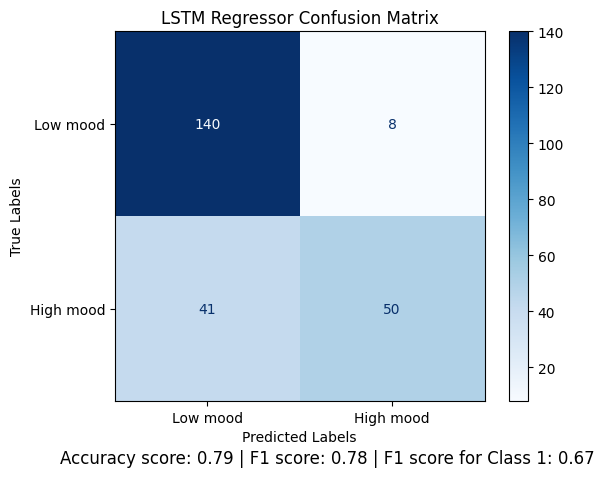

'              precision    recall  f1-score   support\n\n    Low mood       0.77      0.95      0.85       148\n   High mood       0.86      0.55      0.67        91\n\n    accuracy                           0.79       239\n   macro avg       0.82      0.75      0.76       239\nweighted avg       0.81      0.79      0.78       239\n'

In [66]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_score, recall_score, f1_score, precision_recall_fscore_support

def evaluate(y_test, y_pred, model, title):
    class_labels = ['Low mood', 'High mood']
    # Evaluation
    accuracy = accuracy_score(y_test, y_pred)
    # Compute F1 score specifically for Class 1
    _, _, f1_scores, _ = precision_recall_fscore_support(y_test, y_pred, average=None)
    f1_class1 = f1_scores[1]  # F1 score for Class 1

    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f'Accuracy score: {accuracy:.2f}')
    print(f'F1 score: {f1:.2f}')
    print("Classification Report:")
    class_report = classification_report(y_test, y_pred, target_names=class_labels)
    print(class_report)
    print("Confusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))  # Set the figure size
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    ax = disp.plot(cmap=plt.cm.Blues).ax_  # Using a blue color map for the confusion matrix
    ax.set_title(title)
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    # Adjust the text annotation below the plot
    plt.gcf().text(0.5, 0.01, f'Accuracy score: {accuracy:.2f} | F1 score: {f1:.2f} | F1 score for Class 1: {f1_class1:.2f}',
                   ha='center', fontsize=12, verticalalignment='top')
    plt.show()

    return class_report

# Usage example:
title = 'LSTM Regressor Confusion Matrix'
evaluate(y_test_binary, y_pred_binary, model, title)

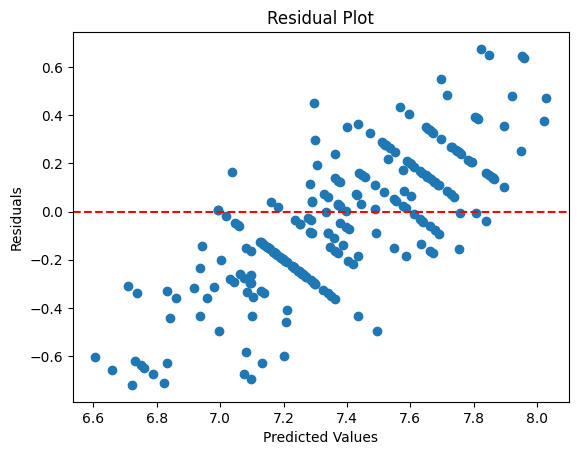

In [55]:
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()


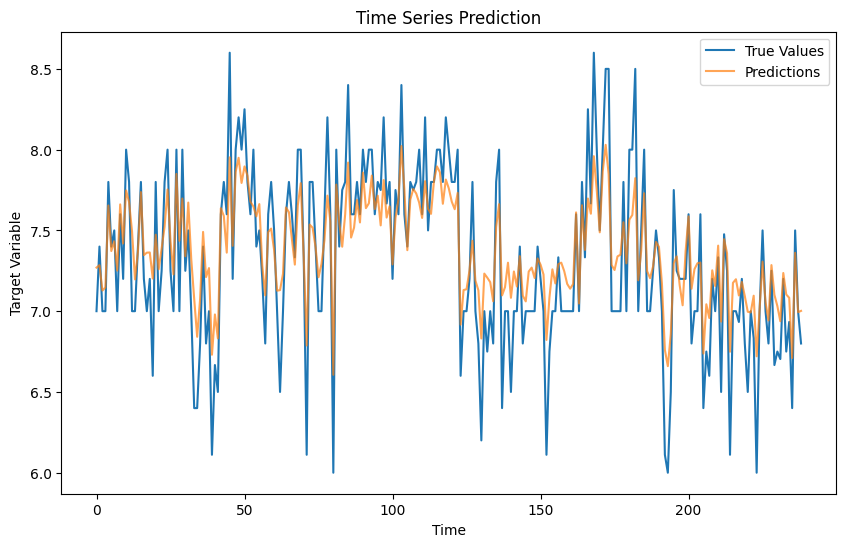

In [57]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.reset_index(drop=True), label='True Values')
plt.plot(y_pred, label='Predictions', alpha=0.7)
plt.title('Time Series Prediction')
plt.xlabel('Time')
plt.ylabel('Target Variable')
plt.legend()
plt.show()